In [8]:
import os
import re
import torch
from torch import nn
import matplotlib.pyplot as plt 
from d2l import torch as d2l
#from d2l1 import torch as d2l1

# 1. TextCNN

# Input

### Read dataset: from pos/neg text.txt

In [2]:
data_dir=os.getcwd()

In [3]:
def read_kick(data_dir, is_train):
    """读取kick文本序列和标签"""
    data, labels = [],[]
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'video_train' if is_train else 'video_test',label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.readlines()
                for i in range(10):
                    try:
                        review[i] = review[i].decode('iso-8859-1')
                        review[i] = review[i].replace('[', '').replace(']', '').replace(',', '').replace('', '')
                        review[i] = review[i].replace("'", "").replace("x00", "").strip()
                        data.append(review[i])
                        labels.append(1 if label == 'pos' else 0)
                    except IndexError:
                        pass
                
    return data,labels


### Preprocess: tokenize(word),vocab(filter),steps(padding&truncate)

In [9]:
train_data=read_kick(data_dir, True)
num_steps=512
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=1, reserved_tokens=['<pad>']) #vocab长度56246
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])


100.34027777777777


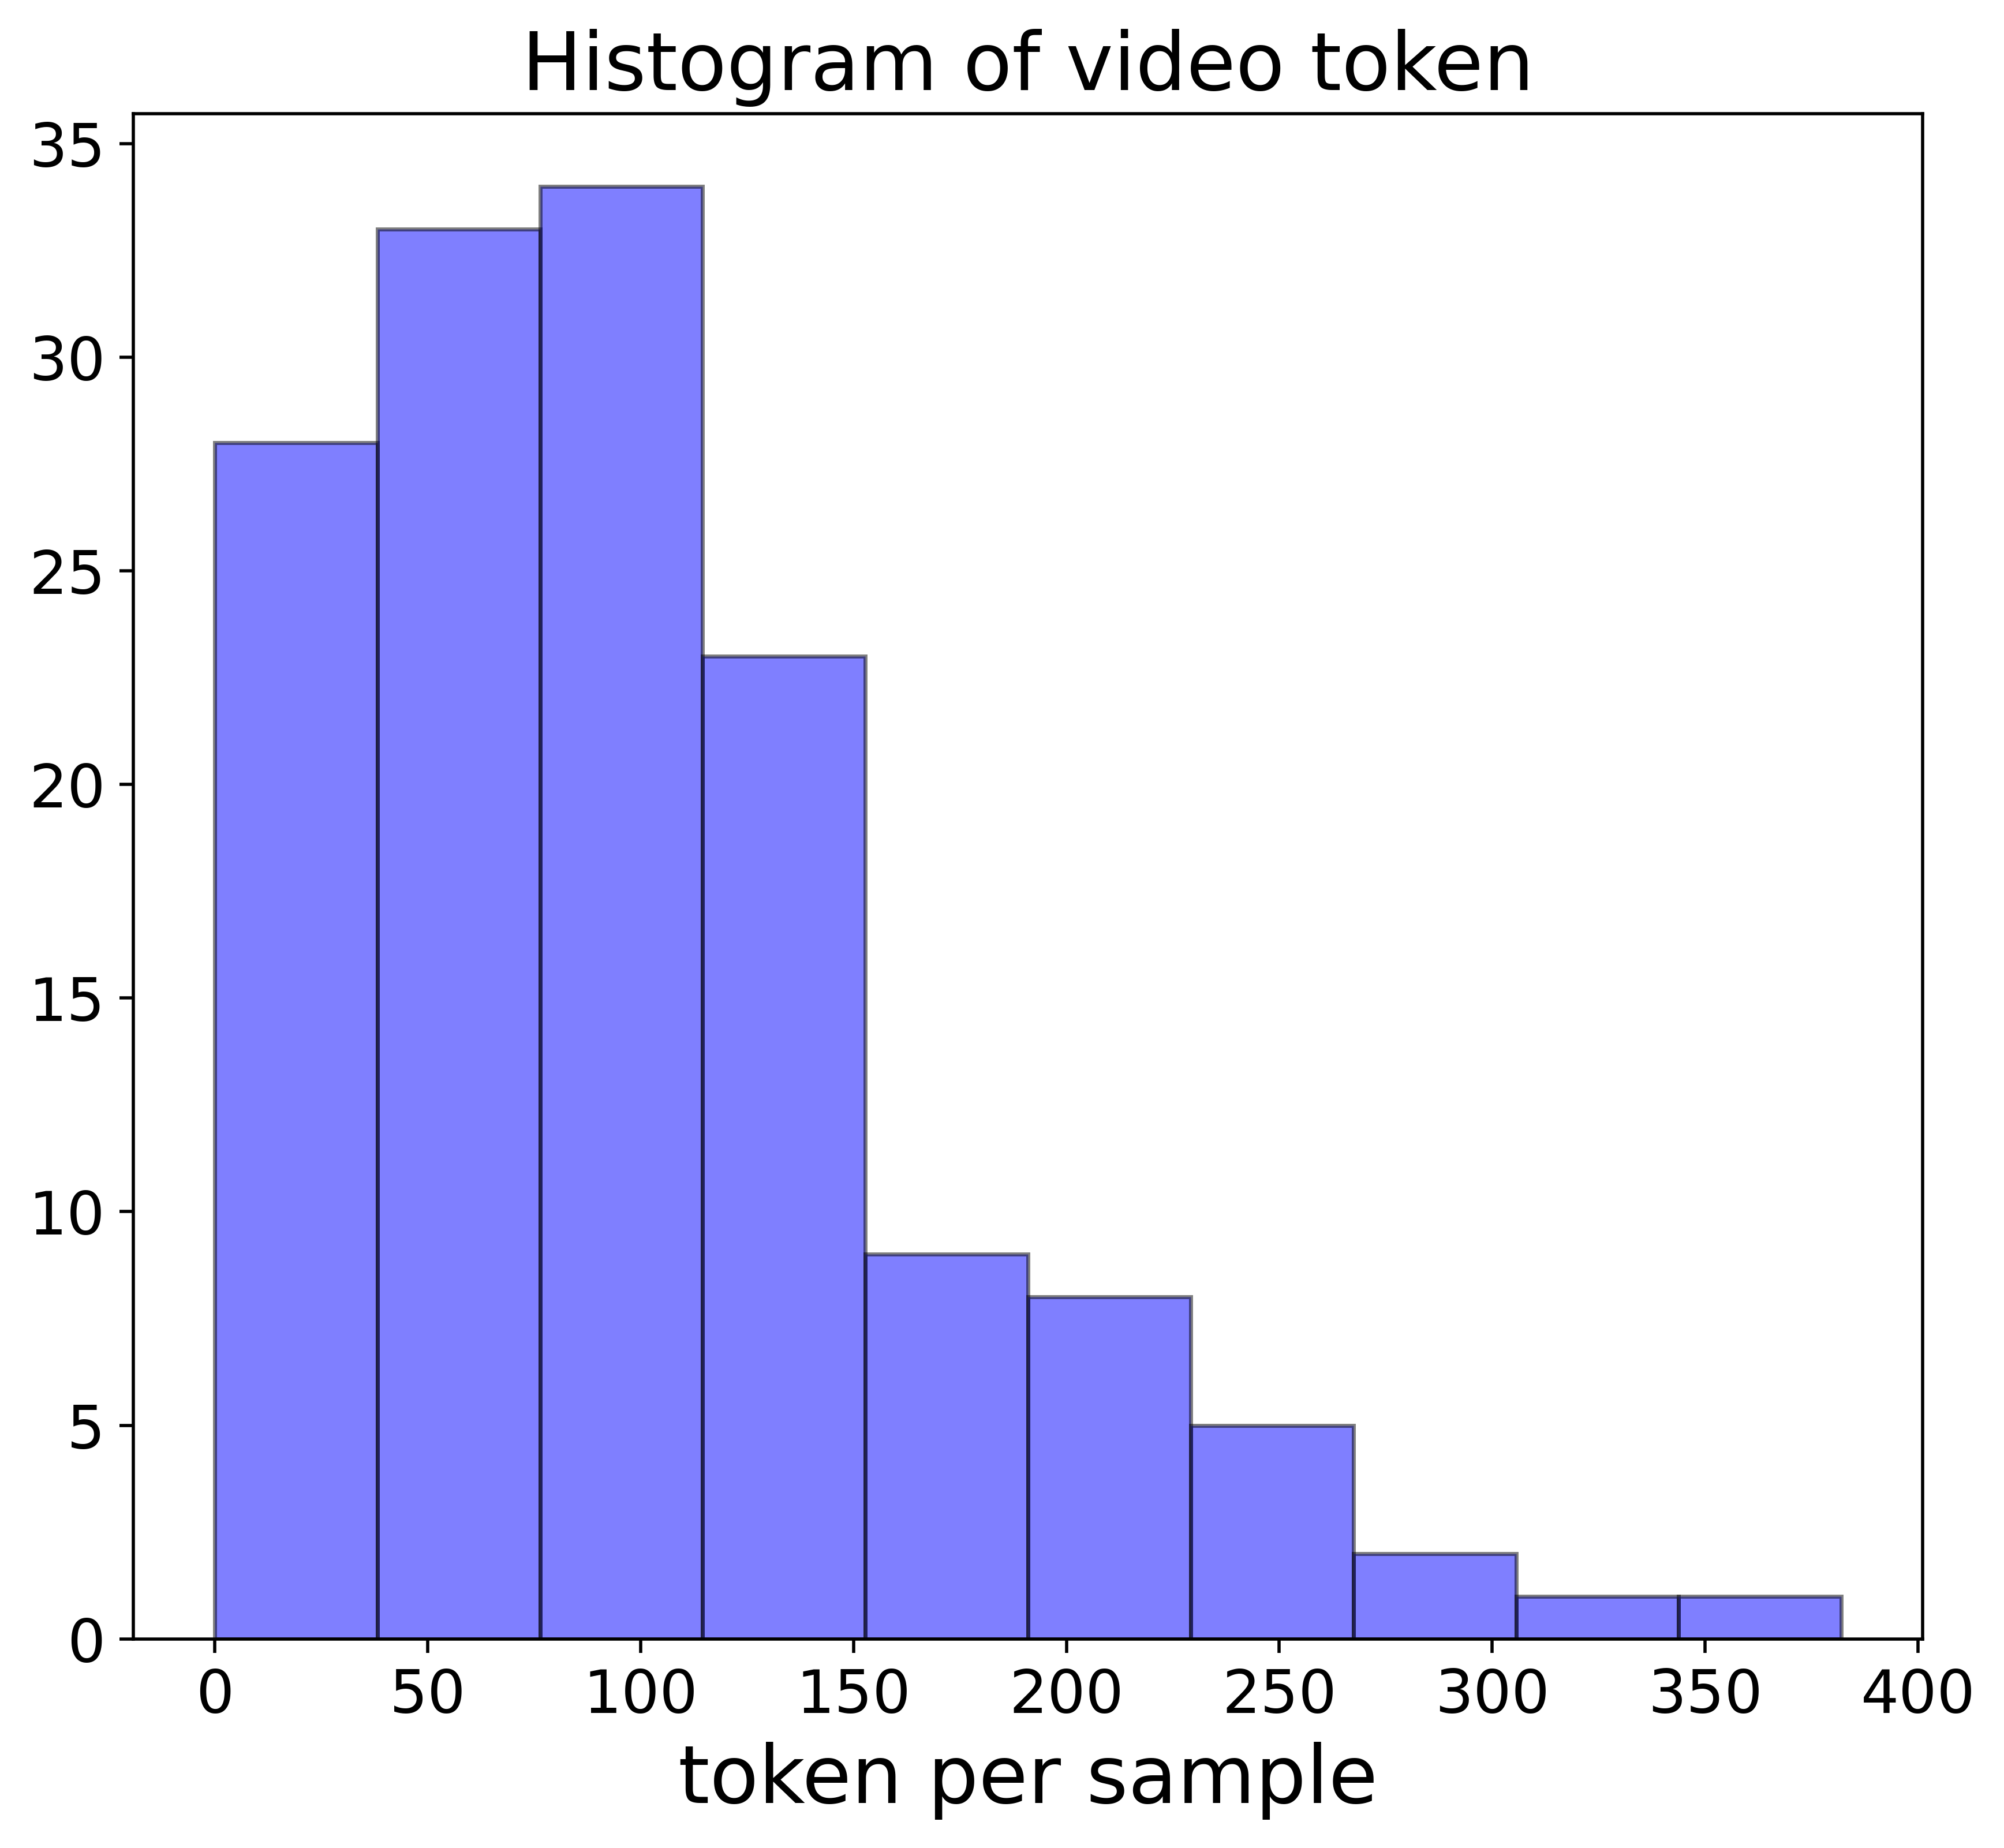

In [13]:
b=[]
for i in range(len(train_tokens)):
    a=len(train_tokens[i])
    b.append(a)
sum(b)
meantoken=sum(b)/len(train_tokens)
print(meantoken)
fig=plt.figure(figsize=(8, 7), dpi=500)
plt.hist(b, bins=10, alpha=0.5, color='blue',edgecolor='black')
plt.title('Histogram of video token',fontsize=20)
plt.xlabel('token per sample',fontsize=20)
#plt.ylabel('counts',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('Histogramofvideotoken.png', dpi=500)
plt.show()

### mini-batch input:train_iter,test_iter,vocab

In [35]:
def load_data_kick(batch_size, num_steps):
    """返回数据迭代器和kickstarter数据集的词表"""
    
    train_data = read_kick(data_dir,True)
    test_data = read_kick(data_dir,False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=1)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

In [36]:
len(vocab)

1327

# Model

In [37]:
batch_size,num_steps =8,512
train_iter, test_iter, vocab = load_data_kick(batch_size,num_steps)

### TextRNN(vocabsize,embedsize,numhidden,numlayer)()

In [38]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 最大时间汇聚层没有参数，因此可以共享此实例
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        embeddings = embeddings.permute(0, 2, 1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

### params initiate

In [39]:
embed_size, kernel_sizes, nums_channels = 100, [3,4,5], [100, 100, 100]
devices=d2l.try_all_gpus()
#devices=d2l1.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

In [40]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

In [41]:
embeds.shape

torch.Size([1326, 100])

# Trainging

loss 0.471, train acc 0.722, test acc 0.500
116.9 examples/sec on [device(type='cpu')]


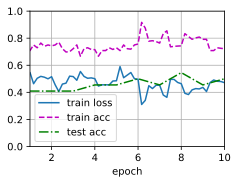

In [44]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
#12;00-12:13-12:19
#14;09

# 2.BiRNN

In [ ]:
batch_size,num_steps = 8,256
train_iter, test_iter, vocab = load_data_kick(batch_size,num_steps)

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [ ]:
embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

In [ ]:
lr, num_epochs = 0.01, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
#d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

# 3.BERT+MLP

In [ ]:
data_dir=os.getcwd()
def read_kick(data_dir, is_train):
    """读取kick文本序列和标签"""
    data1,data2, labels = [],[],[]
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'video_train' if is_train else 'video_test',label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.readlines()
                for i in range(10):
                    try:
                        review[i] = review[i].decode('iso-8859-1')
                        review[i] = review[i].replace('[', '').replace(']', '').replace(',', '').replace('', '')
                        review[i] = review[i].replace("'", "").replace("x00", "").strip()
                        data1.append(review[i])
                        data2.append(review[i])
                        labels.append(1 if label == 'pos' else 0)
                    except IndexError:
                        pass
                
    return data1,data2,labels

In [ ]:
train_data = read_kick(data_dir,is_train=True)
for x0, x1,y in zip(train_data[0][12:16], train_data[1][12:16],train_data[2][12:16]):
    print('p：', x0)
    print('h：', x1)
    print('l：', y)

In [ ]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [ ]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # 定义空词表以加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,
        'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[768],
                         ffn_num_input=768, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=12, num_layers=12, dropout=0.1,
                         max_len=max_len, key_size=768, query_size=768,
                         value_size=768, hid_in_features=768,
                         mlm_in_features=768, nsp_in_features=768)
    # 加载预训练BERT参数
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [ ]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.base', num_hiddens=768, ffn_num_hiddens=3072, num_heads=12,
    num_layers=12, dropout=0.1, max_len=512, devices=devices)

In [ ]:
class KickBertDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [
            p_tokens for p_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # 使用4个进程
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [ ]:
batch_size, max_len, num_workers = 2, 512, d2l.get_dataloader_workers()

train_set = KickBertDataset(read_kick(data_dir,True), max_len, vocab)
test_set = KickBertDataset(read_kick(data_dir,False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(768, 2)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [ ]:
net = BERTClassifier(bert)

In [ ]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)